# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

## WARNING

The analysis below shows that GEOS precomputes envolveop and is therefore faster...

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_mbr -- --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --iterations 300 --headlong
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
                 qps                            
program          geo          geos    geos_twice
count     200.000000    200.000000    200.000000
mean     5627.094048  56825.905744  55800.212927
std       232.866235   1366.396463   2430.695011
min      3627.556667  45141.322132  34449.730832
25%      5657.700634  56124.763001  55341.108035
50%      5679.960173  57397.834840  56561.892335
75%      5693.177285  57684.548858  56900.186860
max      5719.888852  58007.554208  57182.659541


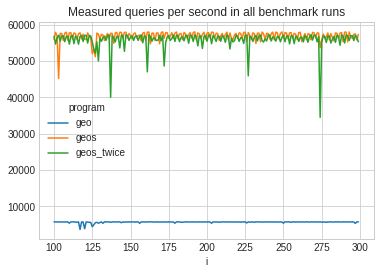

### Statistics: After outlier removal
                 qps                            
program          geo          geos    geos_twice
count     188.000000    188.000000    188.000000
mean     5658.811041  56965.541414  56185.140729
std        76.887225    888.302037    910.840695
min      5289.212556  54668.677745  52616.029526
25%      5659.748447  56165.252413  55407.888733
50%      5680.279602  57421.017718  56592.272565
75%      5694.375649  57684.548858  56907.238265
max      5719.888852  58007.554208  57182.659541


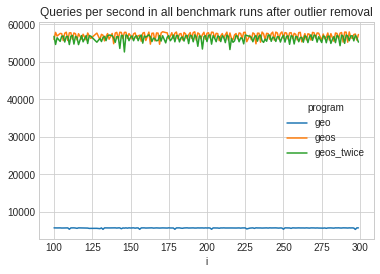

## Ratio of qps compared to geo
                qps            
program        geos  geos_twice
count    188.000000  188.000000
mean      10.068722    9.930764
std        0.216785    0.217187
min        9.563397    9.328500
25%        9.884138    9.765516
50%       10.115858    9.976568
75%       10.166253   10.032486
max       10.851381   10.790604


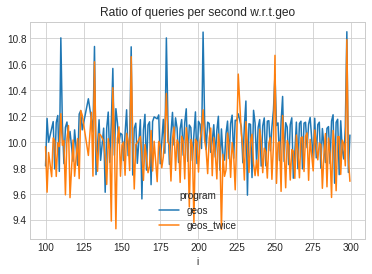

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 990 -g -o ../analysis/benchmark_mbr/perf.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 200 --headlong > /dev/null

cd ../analysis/benchmark_mbr
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

This shows that over 90% time is spent in `geo_types::private_utils::get_bounding_rect`.

In particular, `getEnvelope` in `libgeos` contributes ~0.13% time: ![](./ReportGetEnvelope.png)

-> My assumption that geo is losing out due to bad memory allocations is wrong.